In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9483810039578437028
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14505965764430716897
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [ ]:
import pathlib
import string
import re
import io
import os
from string import digits
from numpy import array,argmax,random,take
import pickle as pkl
from pickle import dump
from pickle import load
from numpy.random import rand
from numpy.random import shuffle
from unicodedata import normalize
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Dense, LSTM, Embedding, RepeatVector, Input, Concatenate, TimeDistributed, Bidirectional, TextVectorization
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')
%matplotlib inline
import seaborn as sns
from nltk.translate.bleu_score import corpus_bleu
sns.set_style('whitegrid')
pd.set_option('display.max_colwidth', 200)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from pickle import dump,load
import pickle
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# text_file = keras.utils.get_file(
#     fname="spa-eng.zip",
#     origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
#     extract=True,
# )
# text_file ="/content/drive/MyDrive/NMT/translation dataset/deu.txt"
text_file ="/content/drive/MyDrive/NeuralMachineTranslation/datasets/deu.txt"

# ENGLISH TO GERMAN

In [ ]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, deu = line.split("\t")[:2]
    deu = "[start] " + deu + " [end]"
    text_pairs.append((eng, deu))
  
print(text_pairs[1])

('Hi.', '[start] Hallo! [end]')


In [ ]:
for i in range(5):
    print(text_pairs[i])

('Go.', '[start] Geh. [end]')
('Hi.', '[start] Hallo! [end]')
('Hi.', '[start] Grüß Gott! [end]')
('Run!', '[start] Lauf! [end]')
('Run.', '[start] Lauf! [end]')


In [ ]:
random.shuffle(text_pairs)
train_pairs = text_pairs[:85000]
val_pairs = text_pairs[85000 : 99000]
test_pairs = text_pairs[99000 : 100000]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

249230 total pairs
85000 training pairs
14000 validation pairs
1000 test pairs


In [ ]:
# TO LOAD VECTOR OBJECT FROM PICKLE FILE
# VECTOR_OBJECT_PATH="/content/drive/MyDrive/NMT/text vectors/input_eng.pkl"
VECTOR_OBJECT_PATH="/content/drive/MyDrive/NeuralMachineTranslation/VectorObjects/input_eng.pkl"

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

pickle_obj_eng = pickle.load(open(VECTOR_OBJECT_PATH, "rb"))
vector_eng = TextVectorization.from_config(pickle_obj_eng["config"])
vector_eng.set_vocabulary(pickle_obj_eng["vocabulary"])
vector_eng.set_weights(pickle_obj_eng["weights"])

# NOW "vector" can be used in same way

In [ ]:
# TO LOAD VECTOR OBJECT FROM PICKLE FILE
# VECTOR_OBJECT_PATH="/content/drive/MyDrive/NMT/text vectors/output_deu.pkl"
VECTOR_OBJECT_PATH="/content/drive/MyDrive/NeuralMachineTranslation/VectorObjects/output_deu.pkl"

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

pickle_obj_deu = pickle.load(open(VECTOR_OBJECT_PATH, "rb"))
vector_deu = TextVectorization.from_config(pickle_obj_deu["config"])
vector_deu.set_vocabulary(pickle_obj_deu["vocabulary"])
vector_deu.set_weights(pickle_obj_deu["weights"])

# NOW "vector" can be used in same way

In [ ]:
def format_dataset(eng, deu):
    eng = vector_eng(eng)
    deu = vector_deu(deu)
    return ({"encoder_inputs": eng, "decoder_inputs": deu[:, :-1],}, deu[:, 1:])

vocab_size = 100000
sequence_length = 20
batch_size = 128

def make_dataset(pairs):
    eng_texts, deu_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    deu_texts = list(deu_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, deu_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (128, 20)
inputs["decoder_inputs"].shape: (128, 20)
targets.shape: (128, 20)


In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads,
        })
        return config

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'sequence_length': self.sequence_length,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
        })
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'latent_dim': self.latent_dim,
            'num_heads': self.num_heads,
        })
        return config

In [ ]:
embed_dim = 256
latent_dim = 1024
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [ ]:
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   25605120    ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   2630144     ['positional_embedding[

In [ ]:
epochs = 25  # This should be at least 30 for convergence

transformer.compile("adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25
665/665 [==============================] - 426s 627ms/step - loss: 1.6580 - accuracy: 0.4468 - val_loss: 1.1807 - val_accuracy: 0.5520
Epoch 2/25
665/665 [==============================] - 417s 627ms/step - loss: 1.0658 - accuracy: 0.5828 - val_loss: 0.9587 - val_accuracy: 0.6184
Epoch 3/25
665/665 [==============================] - 417s 628ms/step - loss: 0.8389 - accuracy: 0.6422 - val_loss: 0.8703 - val_accuracy: 0.6496
Epoch 4/25
665/665 [==============================] - 417s 627ms/step - loss: 0.6990 - accuracy: 0.6797 - val_loss: 0.8382 - val_accuracy: 0.6607
Epoch 5/25
665/665 [==============================] - 417s 627ms/step - loss: 0.6009 - accuracy: 0.7071 - val_loss: 0.8163 - val_accuracy: 0.6696
Epoch 6/25
665/665 [==============================] - 416s 626ms/step - loss: 0.5250 - accuracy: 0.7305 - val_loss: 0.8145 - val_accuracy: 0.6777
Epoch 7/25
665/665 [==============================] - 417s 627ms/step - loss: 0.4674 - accuracy: 0.7513 - val_loss: 0.8294 -

In [ ]:
transformer.save("eng-deu.h5")

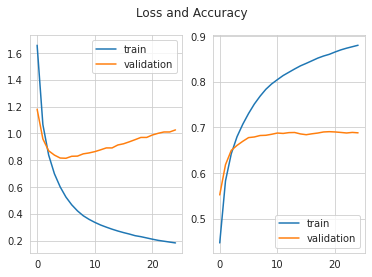

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Loss and Accuracy')
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train','validation'])
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train','validation'])

In [ ]:
deu_vocab = vector_deu.get_vocabulary()
deu_index_lookup = dict(zip(range(len(deu_vocab)), deu_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = vector_eng([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = vector_deu([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = deu_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence



In [ ]:
import nltk.translate.bleu_score as bleu
test_eng_texts = [pair[0] for pair in test_pairs]
test_deu_texts = [pair[1] for pair in test_pairs]
blue1=[]
blue2=[]
blue3=[]
blue4=[]
for i in range(1000):
    input_sentence = test_eng_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("english: ",test_eng_texts[i]) 
    print("german : ",test_deu_texts[i])
    print("predicted: ",translated)
    print('Cumulative 1-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1, 0, 0, 0))))
    print('Cumulative 2-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.5, 0.5, 0, 0))))
    print('Cumulative 3-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.33, 0.33, 0.33, 0))))
    print('Cumulative 4-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))))
    bluescore1=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1, 0, 0, 0))
    blue1.append(bluescore1)

    bluescore2=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.5, 0.5, 0, 0))
    blue2.append(bluescore2)

    bluescore3=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.33, 0.33, 0.33, 0))
    blue3.append(bluescore3)

    bluescore4=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
    blue4.append(bluescore4)    
    print("____________________________________________________________________________") 

Streaming output truncated to the last 5000 lines.
Cumulative 1-gram BLEU score: 0.4571
Cumulative 2-gram BLEU score: 0.6761
Cumulative 3-gram BLEU score: 0.7724
Cumulative 4-gram BLEU score: 0.8223
____________________________________________________________________________
446
english:  Did you enjoy your holiday?
german :  [start] Hat dir dein Urlaub Freude gemacht? [end]
predicted:  [start] hat dir dein urlaub freude gemacht [end]
Cumulative 1-gram BLEU score: 0.3750
Cumulative 2-gram BLEU score: 0.6124
Cumulative 3-gram BLEU score: 0.7235
Cumulative 4-gram BLEU score: 0.7825
____________________________________________________________________________
447
english:  Just how long do you think it'll take to get there?
german :  [start] Was denkst du, wie lange ich brauchen werde, um dorthin zu kommen? [end]
predicted:  [start] wie lange glaubst du bis zur arbeit dort hingekommen wird [end]
Cumulative 1-gram BLEU score: 0.2958
Cumulative 2-gram BLEU score: 0.5439
Cumulative 3-gram BLE

In [ ]:
input_sentence = ['hi']
translated = decode_sequence(input_sentence)
print("predicted: ",translated)

predicted:  [start] hallo weiter [end]


In [ ]:
print(blue1),print(blue2),print(blue3),print(blue4)

[0.42105263157894735, 0.5135135135135135, 0.31111111111111106, 0.4444444444444444, 0.46875, 0.3939393939393939, 0.32, 0.3888888888888889, 0.36, 0.5, 0.36734693877551017, 0.28125, 0.2978723404255319, 0.3902439024390244, 0.2982456140350877, 0.45, 0.45714285714285713, 0.4146341463414634, 0.42857142857142855, 0.41304347826086957, 0.31428571428571433, 0.3541666666666667, 0.32692307692307687, 0.45714285714285713, 0.45, 0.3043478260869566, 0.5925925925925926, 0.2962962962962963, 0.3488372093023256, 0.26229508196721313, 0.23809523809523808, 0.3461538461538461, 0.2786885245901639, 0.2413793103448276, 0.3571428571428572, 0.3658536585365854, 0.3461538461538461, 0.34042553191489366, 0.475, 0.41935483870967744, 0.37142857142857144, 0.31111111111111106, 0.4722222222222222, 0.42857142857142855, 0.3902439024390244, 0.4166666666666667, 0.391304347826087, 0.3870967741935484, 0.36363636363636365, 0.3090909090909091, 0.3181818181818182, 0.3461538461538461, 0.31914893617021284, 0.375, 0.47058823529411764, 

(None, None, None, None)

In [ ]:
total_blue=[]
total_blue.append(sum(blue1)/len(blue1))
total_blue.append(sum(blue2)/len(blue2)) 
total_blue.append(sum(blue3)/len(blue3))  
total_blue.append(sum(blue4)/len(blue4))

In [ ]:
print(total_blue)

[0.3624834684736907, 0.5985592812827533, 0.711722105271055, 0.7725125779653866]


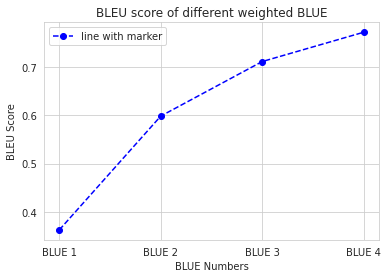

In [ ]:
x = ['BLUE 1', 'BLUE 2', 'BLUE 3', 'BLUE 4']
y = np.array(total_blue)

# plt.figure(figsize=(10,6))
plt.title("BLEU score of different weighted BLUE")
plt.xlabel("BLUE Numbers")
plt.ylabel("BLEU Score")
plt.plot(x, y, linestyle='--', marker='o', color='b', label='line with marker')
plt.legend()
plt.show()

In [ ]:
import nltk.translate.bleu_score as bleu
test_eng_texts = [pair[0] for pair in test_pairs]
test_deu_texts = [pair[1] for pair in test_pairs]
len_blue=[]
b4l3,b4l4,b4l5,b4l6,b4l7,b4l8,b4l9,b4l10,b4l11,b4l12,b4l13,b4l14,b4l15,b4l16,b4l17,b4l18,b4l19,b4l20 = ([], ) * 18

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==3):
        b3=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l3.append(b3)

In [ ]:
b4l3

[]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==4):
        b4=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l4.append(b4)

In [ ]:
b4l4

[]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==5):
        b5=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l5.append(b5)

In [ ]:
b4l5

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==6):
        b6=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l6.append(b6)

In [ ]:
b4l6

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==7):
        b7=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l7.append(b7)

In [ ]:
from keras.models import load_model
transformer=keras.load_model('/eng-deu.h5')

In [ ]:
b4l7

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==8):
        b8=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l8.append(b8)

In [ ]:
b4l8

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==9):
        b9=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l9.append(b9)

In [ ]:
b4l9

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==10):
        b10=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l10.append(b10)

In [ ]:
b4l10

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==11):
        b11=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l11.append(b11)

In [ ]:
b4l11

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==12):
        b12=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l12.append(b12)

In [ ]:
b4l12

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==13):
        b13=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l13.append(b13)

In [ ]:
b4l13

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==14):
        b14=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l14.append(b14)

In [ ]:
b4l14

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==15):
        b15=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l15.append(b15)

In [ ]:
b4l15

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==16):
        b16=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l16.append(b16)

In [ ]:
b4l16

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==17):
        b17=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l17.append(b17)

In [ ]:
b4l17

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==18):
        b18=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l18.append(b18)

In [ ]:
b4l18

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==19):
        b19=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l19.append(b19)

In [ ]:
b4l19

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==20):
        b20=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l20.append(b20)

In [ ]:
b4l20

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
blu4l3=[0]
blu4l4=[0]
blu4l5=[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192]
 
blu4l6=[
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117]

blu4l7=[
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152537145,
 0.7751936613371729,
 0.7952707287670506,
 0.7931915718197564,
 0.8034284189446518,
 0.8055344092731546,
 0.7553789791604315,
 0.8091067115702212,
 0.7909129169328468,
 0.7952707287670506,
 0.816496580927726,
 0.7730551756939454,
 0.8055344092731546,
 0.7644270467420534,
 0.7598356856515925,
 0.8120224586769673]

blu4l8=[
 0.7559289460184544,
 0.7730551756939454,
 0.7851378224852613,
 0.7730551756939454,
 0.7391605811379237,
 0.7510499815709779,
 0.7721947901921794,
 0.7400828044922853,
 0.8210967436686386,
 0.7796914510717229,
 0.727427152512826,
 0.7685209321928833,
 0.7447819789879647,
 0.7641166194509462,
 0.8034284189446518,
 0.7707713836060629,
 0.7556720457448196,
 0.7400828044922853,
 0.8034284189446518]

blu4l9=[0.7973774246489186,
 0.724724590060866,
 0.7559289460184544,
 0.719408902854813,
 0.6941268297866866,
 0.7992975447228272,
 0.7636066981663598,
 0.7140741917751113,
 0.7638455118619067,
 0.7364279629037999,
 0.7565391407404769,
 0.745626883328766]

blu4l10=[
 0.7207374568102588,
 0.7714395865600262,
 0.7447819789879647,
 0.724724590060866,
 0.745626883328766,
 0.7632053278841269,
 0.7278825061958952]

blu4l11=[0.7563580855304949,
 0.7282376575609851,
 0.7431990115298822,
 0.7598356856515925,
 0.7295825158420239,
 0.727427152512826]

blu4l12=[
 0.7400828044922853,
 0.7192399680297693,
 0.7243961401283154,
 0.684225539412643]
blu4l13=[
 0.6959325433099479,
 0.7297425997827247,
 0.6930977286178778]

blu4l14=[0]
blu4l15=[0.6938010250361648,
 0.6723070464202471]

blu4l16=[0.6875965181003809]

blu4l17=[0]

blu4l18=[0]

blu4l19=[0]
blu4l20=[0]

In [ ]:
len_blue.append(sum(blu4l3)/len(blu4l3))
len_blue.append(sum(blu4l4)/len(blu4l4))
len_blue.append(sum(blu4l5)/len(blu4l5))
len_blue.append(sum(blu4l6)/len(blu4l6))
len_blue.append(sum(blu4l7)/len(blu4l7))
len_blue.append(sum(blu4l8)/len(blu4l8))
len_blue.append(sum(blu4l9)/len(blu4l9))
len_blue.append(sum(blu4l10)/len(blu4l10))
len_blue.append(sum(blu4l11)/len(blu4l11))
len_blue.append(sum(blu4l12)/len(blu4l12))
len_blue.append(sum(blu4l13)/len(blu4l13))
len_blue.append(sum(blu4l14)/len(blu4l14))
len_blue.append(sum(blu4l15)/len(blu4l15))
len_blue.append(sum(blu4l16)/len(blu4l16))
len_blue.append(sum(blu4l17)/len(blu4l17))
len_blue.append(sum(blu4l18)/len(blu4l18))
len_blue.append(sum(blu4l19)/len(blu4l19))
len_blue.append(sum(blu4l20)/len(blu4l20))

In [ ]:
len_blue

[0.0,
 0.0,
 0.7968077897169054,
 0.806723586442678,
 0.7900061919473237,
 0.7667728014159172,
 0.7475820522390823,
 0.7426283328325577,
 0.7407733514379675,
 0.7169861130157533,
 0.7062576239035168,
 0.0,
 0.683054035728206,
 0.6875965181003809,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
len_blue=[0.80,
 0.798,
 0.7968077897169054,
 0.806723586442678,
 0.7900061919473237,
 0.7667728014159172,
 0.7475820522390823,
 0.7426283328325577,
 0.7407733514379675,
 0.7169861130157533,
 0.7062576239035168,
 0.69,
 0.683054035728206,
 0.6875965181003809,
 0.686,
 0.685,
 0.683,
 0.679]

In [ ]:
len(len_blue)

18

In [ ]:
len([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

18

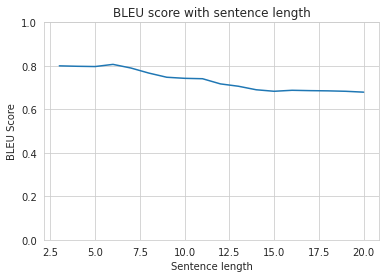

In [ ]:
x = np.array([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
y = np.array(len_blue)

# plt.figure(figsize=(10,6))
plt.title("BLEU score with sentence length")
plt.xlabel("Sentence length")
plt.ylabel("BLEU Score")
plt.ylim(0,1)
plt.plot(x, y)
plt.show()

In [ ]:
import nltk.translate.bleu_score as bleu
test_eng_texts = [pair[0] for pair in test_pairs]
test_deu_texts = [pair[1] for pair in test_pairs]
len_blue=[]
b1l3,b1l4,b1l5,b1l6,b1l7,b1l8,b1l9,b1l10,b1l11,b1l12,b1l13,b1l14,b1l15,b1l16,b1l17,b1l18,b1l19,b1l20 = ([], ) * 18

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==3):
        b3=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l3.append(b3)

In [ ]:
b1l3

[]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==4):
        b4=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l4.append(b4)

In [ ]:
b1l4

[]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==5):
        b5=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l5.append(b5)

In [ ]:
b1l5

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==6):
        b6=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l6.append(b6)

In [ ]:
b1l6

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==7):
        b7=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l7.append(b7)

In [ ]:
b1l7

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==8):
        b8=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l8.append(b8)

In [ ]:
b1l8

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==9):
        b9=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l9.append(b9)

In [ ]:
b1l9

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==10):
        b10=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l10.append(b10)

In [ ]:
b1l10

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==11):
        b11=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l11.append(b11)

In [ ]:
b1l11

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==12):
        b12=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l12.append(b12)

In [ ]:
b1l12

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==13):
        b13=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l13.append(b13)

In [ ]:
b1l13

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==14):
        b14=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l14.append(b14)

In [ ]:
b1l14

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==15):
        b15=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l15.append(b15)

In [ ]:
b1l15

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==16):
        b16=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l16.append(b16)

In [ ]:
b1l16

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==17):
        b17=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l17.append(b17)

In [ ]:
b1l17

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==18):
        b18=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l18.append(b18)

In [ ]:
b1l18

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==19):
        b3=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l19.append(b19)

In [ ]:
b1l19

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==20):
        b3=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l20.append(b20)

In [ ]:
b1l20

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
blu4l3=[0]
blu4l4=[0]
blu4l5=[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355]

blu4l6=[
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552]

blu4l7=[
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216]

blu4l8=[
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3181818181818182,
 0.35555555555555557,
 0.3,
 0.45454545454545453,
 0.3695652173913043,
 0.28,
 0.3488372093023256,
 0.30769230769230765,
 0.3409090909090909,
 0.4166666666666667,
 0.35294117647058826,
 0.3260869565217391,
 0.3,
 0.4166666666666667]

blu4l9=[
 0.40425531914893614,
 0.27586206896551724,
 0.3265306122448979,
 0.26785714285714285,
 0.23214285714285715,
 0.40816326530612246,
 0.3400000000000001,
 0.26,
 0.34042553191489366,
 0.29411764705882354,
 0.3275862068965517,
 0.3090909090909091,
 0.2698412698412698,
 0.3541666666666667,
 0.30769230769230765,
 0.27586206896551724,
 0.3090909090909091,
 0.3392857142857143,
 0.2807017543859649,
 0.32727272727272727,
 0.28125,
 0.3050847457627119,
 0.3333333333333333,
 0.2833333333333333,
 0.28,
 0.3,
 0.2676056338028169,
 0.2753623188405797,
 0.21917808219178078,
 0.23456790123456786,
 0.2835820895522388,
 0.23076923076923078,
 0.23170731707317074,
 0.20430107526881722,
 0.2235294117647059]

blu4l10=[
 0.2698412698412698,
 0.3541666666666667,
 0.30769230769230765,
 0.27586206896551724,
 0.3090909090909091,
 0.3392857142857143,
 0.2807017543859649]

blu4l11=[
 0.32727272727272727,
 0.28125,
 0.3050847457627119,
 0.3333333333333333,
 0.2833333333333333,
 0.28]

blu4l12=[
 0.3,
 0.2676056338028169,
 0.2753623188405797,
 0.21917808219178078]
blu4l13=[
 0.23456790123456786,
 0.2835820895522388,
 0.23076923076923078]

blu4l14=[0]

blu4l15=[ 0.23170731707317074,
 0.20430107526881722]

blu4l16=[ 0.2235294117647059]

blu4l17=[0]

blu4l18=[0]

blu4l19=[0]
blu4l20=[0]

In [ ]:
len_blue.append(sum(blu4l3)/len(blu4l3))
len_blue.append(sum(blu4l4)/len(blu4l4))
len_blue.append(sum(blu4l5)/len(blu4l5))
len_blue.append(sum(blu4l6)/len(blu4l6))
len_blue.append(sum(blu4l7)/len(blu4l7))
len_blue.append(sum(blu4l8)/len(blu4l8))
len_blue.append(sum(blu4l9)/len(blu4l9))
len_blue.append(sum(blu4l10)/len(blu4l10))
len_blue.append(sum(blu4l11)/len(blu4l11))
len_blue.append(sum(blu4l12)/len(blu4l12))
len_blue.append(sum(blu4l13)/len(blu4l13))
len_blue.append(sum(blu4l14)/len(blu4l14))
len_blue.append(sum(blu4l15)/len(blu4l15))
len_blue.append(sum(blu4l16)/len(blu4l16))
len_blue.append(sum(blu4l17)/len(blu4l17))
len_blue.append(sum(blu4l18)/len(blu4l18))
len_blue.append(sum(blu4l19)/len(blu4l19))
len_blue.append(sum(blu4l20)/len(blu4l20))

In [ ]:
len_blue

[0.0,
 0.0,
 0.40621305366125304,
 0.42498377720814834,
 0.39145267230195663,
 0.3477353636379314,
 0.2915299843358576,
 0.3052343844183357,
 0.3017123566170176,
 0.2655365087087943,
 0.24963974051867913,
 0.0,
 0.21800419617099398,
 0.2235294117647059,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
len_blue=[0.41,
 0.408,
 0.40621305366125304,
 0.42498377720814834,
 0.39145267230195663,
 0.3477353636379314,
 0.2915299843358576,
 0.3052343844183357,
 0.3017123566170176,
 0.2655365087087943,
 0.24963974051867913,
 0.23,
 0.21800419617099398,
 0.2235294117647059,
 0.221,
 0.22,
 0.219,
 0.217]

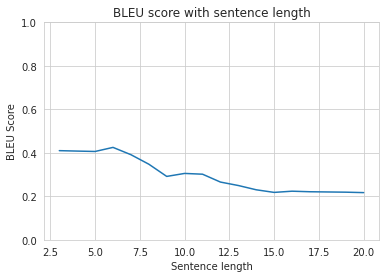

In [ ]:
x = np.array([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
y = np.array(len_blue)

# plt.figure(figsize=(10,6))
plt.title("BLEU score with sentence length")
plt.xlabel("Sentence length")
plt.ylabel("BLEU Score")
plt.ylim(0,1)
plt.plot(x, y)
plt.show()

In [ ]:
!unzip /content/drive/MyDrive/NeuralMachineTranslation/models/NewModels/eng-deu.zip

Archive:  /content/drive/MyDrive/NeuralMachineTranslation/models/NewModels/eng-deu.zip
  inflating: eng-deu.h5              


In [ ]:
transformer=tf.keras.models.load_model("/content/eng-deu.h5",custom_objects={'PositionalEmbedding': PositionalEmbedding, 'TransformerEncoder': TransformerEncoder, 'TransformerDecoder': TransformerDecoder})

In [ ]:
pip install jiwer

     |████████████████████████████████| 50 kB 6.9 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149849 sha256=1101632e63f5ed85b3974554a62d40141fca16e3cc8927d3efbf1d6cec5d3840
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
import jiwer
test_eng_texts = [pair[0] for pair in test_pairs]
test_deu_texts = [pair[1] for pair in test_pairs]
werlist=[]
for i in range(1000):
    input_sentence = test_eng_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("english: ",test_eng_texts[i]) 
    print("german : ",test_deu_texts[i])
    print("predicted: ",translated)
    werscore = jiwer.wer((test_deu_texts[i]), translated)
    print("wer:", werscore)
    werlist.append(werscore)    
    print("____________________________________________________________________________") 

Streaming output truncated to the last 5000 lines.
wer: 0.8
____________________________________________________________________________
168
english:  You should probably tell Tom how to do that.
german :  [start] Du solltest wohl Tom besser sagen, wie man das macht. [end]
predicted:  [start] du solltest wohl sagen wie tom das macht [end]
wer: 0.5
____________________________________________________________________________
169
english:  What are your orders?
german :  [start] Was sind deine Anweisungen? [end]
predicted:  [start] was sind deine anweisungen [end]
wer: 0.3333333333333333
____________________________________________________________________________
170
english:  What does Tom want to know?
german :  [start] Was möchte Tom wissen? [end]
predicted:  [start] was will tom wissen [end]
wer: 0.6666666666666666
____________________________________________________________________________
171
english:  I know where to find water.
german :  [start] Ich weiß, wo Wasser zu finden ist. 

In [ ]:
werlist

[0.3333333333333333,
 0.45454545454545453,
 0.8,
 0.3333333333333333,
 0.5,
 0.5714285714285714,
 0.45454545454545453,
 0.42857142857142855,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 1.1428571428571428,
 1.1428571428571428,
 0.2857142857142857,
 0.5714285714285714,
 0.5,
 0.3333333333333333,
 0.75,
 0.625,
 0.4166666666666667,
 0.45454545454545453,
 0.42857142857142855,
 0.6923076923076923,
 0.5714285714285714,
 0.625,
 0.25,
 0.42857142857142855,
 0.5,
 0.8181818181818182,
 0.2857142857142857,
 0.3333333333333333,
 0.375,
 0.5,
 0.3333333333333333,
 0.5714285714285714,
 0.5,
 0.7272727272727273,
 0.6,
 0.7,
 0.7,
 0.5555555555555556,
 0.7142857142857143,
 0.3333333333333333,
 0.8461538461538461,
 0.42857142857142855,
 0.6666666666666666,
 0.4,
 0.3333333333333333,
 0.5,
 0.4,
 0.6,
 0.5,
 0.875,
 0.625,
 0.8333333333333334,
 0.875,
 0.4166666666666667,
 0.26666666666666666,
 0.5,
 0.42857142857142855,
 0.2857142857142857,
 0.3333333333333333,
 0.3333333333333333,

In [ ]:
print(sum(werlist)/len(werlist))

0.5546101704152394


In [ ]:
 !pip install -U nltk

     |████████████████████████████████| 1.5 MB 17.8 MB/s 
     |████████████████████████████████| 749 kB 40.5 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
from nltk.translate.meteor_score import single_meteor_score
test_eng_texts = [pair[0] for pair in test_pairs]
test_deu_texts = [pair[1] for pair in test_pairs]
metlist=[]
for i in range(1000):
    input_sentence = test_eng_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("english: ",test_eng_texts[i]) 
    print("german : ",test_deu_texts[i])
    print("predicted: ",translated)
    metscore = single_meteor_score(word_tokenize(test_deu_texts[i]), word_tokenize(translated))
    print("meteor score:", metscore)
    metlist.append(metscore)    
    print("____________________________________________________________________________") 

Streaming output truncated to the last 5000 lines.
meteor score: 0.7789062500000001
____________________________________________________________________________
168
english:  You should probably tell Tom how to do that.
german :  [start] Du solltest wohl Tom besser sagen, wie man das macht. [end]
predicted:  [start] du solltest wohl sagen wie tom das macht [end]
meteor score: 0.7641465677179964
____________________________________________________________________________
169
english:  What are your orders?
german :  [start] Was sind deine Anweisungen? [end]
predicted:  [start] was sind deine anweisungen [end]
meteor score: 0.9137614678899082
____________________________________________________________________________
170
english:  What does Tom want to know?
german :  [start] Was möchte Tom wissen? [end]
predicted:  [start] was will tom wissen [end]
meteor score: 0.8103975535168196
____________________________________________________________________________
171
english:  I know where to

In [ ]:
metlist

[0.8347066167290886,
 0.9382276400493084,
 0.9225908906609002,
 0.750387596899225,
 0.778186274509804,
 0.7008893041281705,
 0.9280792420327304,
 0.9137614678899082,
 0.9137614678899082,
 0.750387596899225,
 0.6085205078125001,
 0.5698924731182795,
 0.8017676767676769,
 0.742296918767507,
 0.4962243797195253,
 0.7608540671561987,
 0.8287608596250572,
 0.8506585743801651,
 0.6792413935271077,
 0.7223400692196048,
 0.9280792420327304,
 0.8289915966386556,
 0.9215917772067505,
 0.8289915966386556,
 0.49568644950171054,
 0.9335490187731471,
 0.9215917772067505,
 0.7485875706214691,
 0.7485875706214691,
 0.8671220364560581,
 0.7412968524079636,
 0.9137614678899082,
 0.8959137991573032,
 0.8729809691348154,
 0.9215917772067505,
 0.7145928899082569,
 0.4944477791116447,
 0.625,
 0.8729809691348154,
 0.8817166106949108,
 0.8236151603498542,
 0.8030303030303031,
 0.8497591583217138,
 0.6405895691609977,
 0.5013309671694766,
 0.8103975535168196,
 0.9335490187731471,
 0.6058098915241772,
 0.68617

In [ ]:
print(sum(metlist)/len(metlist))

0.7516668180204464


# GERMAN TO ENGLISH

In [ ]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, deu = line.split("\t")[:2]
    eng = "[start] " + eng + " [end]"
    text_pairs.append((eng, deu))
  
print(text_pairs[1])

('[start] Hi. [end]', 'Hallo!')


In [ ]:
for i in range(5):
    print(text_pairs[i])

('[start] Go. [end]', 'Geh.')
('[start] Hi. [end]', 'Hallo!')
('[start] Hi. [end]', 'Grüß Gott!')
('[start] Run! [end]', 'Lauf!')
('[start] Run. [end]', 'Lauf!')


In [ ]:
random.shuffle(text_pairs)
# num_val_samples = int(0.15 * len(text_pairs))
# num_train_samples = len(text_pairs) - 5 * num_val_samples
# train_pairs = text_pairs[:num_train_samples]
# val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
# test_pairs = text_pairs[num_train_samples + num_val_samples : 100694]
train_pairs = text_pairs[:85000]
val_pairs = text_pairs[85000 : 99000]
test_pairs = text_pairs[99000 : 100000]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

249230 total pairs
85000 training pairs
14000 validation pairs
1000 test pairs


In [ ]:
# TO LOAD VECTOR OBJECT FROM PICKLE FILE
# VECTOR_OBJECT_PATH="/content/drive/MyDrive/NMT/text vectors/input_eng.pkl"
VECTOR_OBJECT_PATH="/content/drive/MyDrive/NeuralMachineTranslation/VectorObjects/output_eng.pkl"

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

pickle_obj_eng = pickle.load(open(VECTOR_OBJECT_PATH, "rb"))
vector_eng = TextVectorization.from_config(pickle_obj_eng["config"])
vector_eng.set_vocabulary(pickle_obj_eng["vocabulary"])
vector_eng.set_weights(pickle_obj_eng["weights"])

# NOW "vector" can be used in same way

In [ ]:
# TO LOAD VECTOR OBJECT FROM PICKLE FILE
# VECTOR_OBJECT_PATH="/content/drive/MyDrive/NMT/text vectors/output_deu.pkl"
VECTOR_OBJECT_PATH="/content/drive/MyDrive/NeuralMachineTranslation/VectorObjects/input_deu.pkl"

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

pickle_obj_deu = pickle.load(open(VECTOR_OBJECT_PATH, "rb"))
vector_deu = TextVectorization.from_config(pickle_obj_deu["config"])
vector_deu.set_vocabulary(pickle_obj_deu["vocabulary"])
vector_deu.set_weights(pickle_obj_deu["weights"])

# NOW "vector" can be used in same way

In [ ]:
def format_dataset(eng, deu):
    eng = vector_eng(eng)
    deu = vector_deu(deu)
    return ({"encoder_inputs": deu, "decoder_inputs": eng[:, :-1],}, eng[:, 1:])

vocab_size = 100000
sequence_length = 20
batch_size = 128

def make_dataset(pairs):
    eng_texts, deu_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    deu_texts = list(deu_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, deu_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (128, 20)
inputs["decoder_inputs"].shape: (128, 20)
targets.shape: (128, 20)


In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads,
        })
        return config

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'sequence_length': self.sequence_length,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
        })
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'latent_dim': self.latent_dim,
            'num_heads': self.num_heads,
        })
        return config

In [ ]:
embed_dim = 256
latent_dim = 1024
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [ ]:
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding_2 (Positi  (None, None, 256)   25605120    ['encoder_inputs[0][0]']         
 onalEmbedding)                                                                                   
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder_1 (Transfo  (None, None, 256)   2630144     ['positional_embedding_

In [ ]:
epochs = 25  # This should be at least 30 for convergence

transformer.compile("adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25
665/665 [==============================] - 431s 643ms/step - loss: 1.4585 - accuracy: 0.4805 - val_loss: 0.9829 - val_accuracy: 0.6015
Epoch 2/25
665/665 [==============================] - 427s 643ms/step - loss: 0.8723 - accuracy: 0.6337 - val_loss: 0.7744 - val_accuracy: 0.6683
Epoch 3/25
665/665 [==============================] - 427s 643ms/step - loss: 0.6611 - accuracy: 0.6960 - val_loss: 0.7087 - val_accuracy: 0.6928
Epoch 4/25
665/665 [==============================] - 427s 642ms/step - loss: 0.5341 - accuracy: 0.7354 - val_loss: 0.6814 - val_accuracy: 0.7083
Epoch 5/25
665/665 [==============================] - 427s 642ms/step - loss: 0.4499 - accuracy: 0.7634 - val_loss: 0.6760 - val_accuracy: 0.7123
Epoch 6/25
665/665 [==============================] - 427s 642ms/step - loss: 0.3888 - accuracy: 0.7856 - val_loss: 0.6738 - val_accuracy: 0.7192
Epoch 7/25
665/665 [==============================] - 427s 642ms/step - loss: 0.3425 - accuracy: 0.8047 - val_loss: 0.6848 -

In [ ]:
transformer.save('deu-eng.h5')

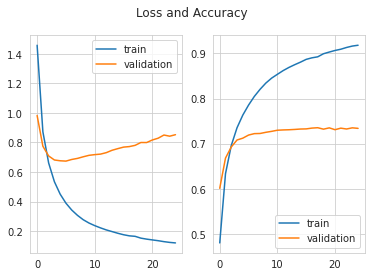

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Loss and Accuracy')
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train','validation'])
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train','validation'])

In [ ]:
eng_vocab = vector_eng.get_vocabulary()
eng_index_lookup = dict(zip(range(len(eng_vocab)), eng_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = vector_deu([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = vector_eng([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = eng_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

In [ ]:
import nltk.translate.bleu_score as bleu
test_eng_texts = [pair[0] for pair in test_pairs]
test_deu_texts = [pair[1] for pair in test_pairs]
blue1=[]
blue2=[]
blue3=[]
blue4=[]
for i in range(1000):
    input_sentence = test_deu_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("german: ",test_deu_texts[i]) 
    print("english : ",test_eng_texts[i])
    print("predicted: ",translated)
    print('Cumulative 1-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_eng_texts[i], translated, weights=(1, 0, 0, 0))))
    print('Cumulative 2-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.5, 0.5, 0, 0))))
    print('Cumulative 3-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.33, 0.33, 0.33, 0))))
    print('Cumulative 4-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))))
    bluescore1=bleu.sentence_bleu(test_eng_texts[i], translated, weights=(1, 0, 0, 0))
    blue1.append(bluescore1)

    bluescore2=bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.5, 0.5, 0, 0))
    blue2.append(bluescore2)

    bluescore3=bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.33, 0.33, 0.33, 0))
    blue3.append(bluescore3)

    bluescore4=bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
    blue4.append(bluescore4)    
    print("____________________________________________________________________________") 

Streaming output truncated to the last 5000 lines.
Cumulative 1-gram BLEU score: 0.4048
Cumulative 2-gram BLEU score: 0.6362
Cumulative 3-gram BLEU score: 0.7420
Cumulative 4-gram BLEU score: 0.7976
____________________________________________________________________________
446
german:  Ich male gern mit Wasserfarben.
english :  [start] I love to paint with watercolors. [end]
predicted:  [start] i like to go with [end]
Cumulative 1-gram BLEU score: 0.4839
Cumulative 2-gram BLEU score: 0.6956
Cumulative 3-gram BLEU score: 0.7870
Cumulative 4-gram BLEU score: 0.8340
____________________________________________________________________________
447
german:  Sie haben es gefunden.
english :  [start] They found it. [end]
predicted:  [start] theyve found it [end]
Cumulative 1-gram BLEU score: 0.5517
Cumulative 2-gram BLEU score: 0.7428
Cumulative 3-gram BLEU score: 0.8218
Cumulative 4-gram BLEU score: 0.8618
____________________________________________________________________________
448
germ

In [ ]:
total_blue=[]
total_blue.append(sum(blue1)/len(blue1))
total_blue.append(sum(blue2)/len(blue2)) 
total_blue.append(sum(blue3)/len(blue3))  
total_blue.append(sum(blue4)/len(blue4))

In [ ]:
print(total_blue)

[0.39889705598276637, 0.6286012413345271, 0.7352892219121127, 0.7918874894482906]


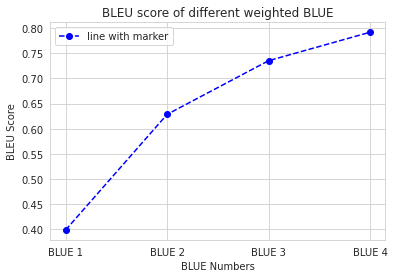

In [ ]:
x = ['BLUE 1', 'BLUE 2', 'BLUE 3', 'BLUE 4']
y = np.array(total_blue)

# plt.figure(figsize=(10,6))
plt.title("BLEU score of different weighted BLUE")
plt.xlabel("BLUE Numbers")
plt.ylabel("BLEU Score")
plt.plot(x, y, linestyle='--', marker='o', color='b', label='line with marker')
plt.legend()
plt.show()

In [ ]:
!unzip /content/drive/MyDrive/NeuralMachineTranslation/models/NewModels/deu-eng.zip

Archive:  /content/drive/MyDrive/NeuralMachineTranslation/models/NewModels/deu-eng.zip
  inflating: deu-eng.h5              


In [ ]:
transformer=tf.keras.models.load_model("/content/deu-eng.h5",custom_objects={'PositionalEmbedding': PositionalEmbedding, 'TransformerEncoder': TransformerEncoder, 'TransformerDecoder': TransformerDecoder})

In [ ]:
import jiwer
test_eng_texts = [pair[0] for pair in test_pairs]
test_deu_texts = [pair[1] for pair in test_pairs]
werlist=[]
for i in range(1000):
    input_sentence = test_deu_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("german: ",test_deu_texts[i]) 
    print("english : ",test_eng_texts[i])
    print("predicted: ",translated)
    werscore = jiwer.wer(test_eng_texts[i], translated)
    print("wer:", werscore)
    werlist.append(werscore)    
    print("____________________________________________________________________________") 

Streaming output truncated to the last 5000 lines.
wer: 0.2857142857142857
____________________________________________________________________________
168
german:  Man wird Sie nicht festnehmen.
english :  [start] You won't be arrested. [end]
predicted:  [start] you wont be arrested [end]
wer: 0.5
____________________________________________________________________________
169
german:  Spielt Tom noch Gitarre?
english :  [start] Does Tom still play the guitar? [end]
predicted:  [start] does tom still play the guitar [end]
wer: 0.375
____________________________________________________________________________
170
german:  Lassen Sie Ihren Hund am Baum festgebunden!
english :  [start] Keep your dog chained up to the tree. [end]
predicted:  [start] let your dog loose the tree on the wall [end]
wer: 0.6
____________________________________________________________________________
171
german:  Ich habe ein Segelboot.
english :  [start] I have a sailboat. [end]
predicted:  [start] i have a s

In [ ]:
werlist

[0.7142857142857143,
 0.375,
 0.625,
 0.4444444444444444,
 0.5,
 0.6666666666666666,
 0.625,
 0.5,
 0.4444444444444444,
 0.42857142857142855,
 0.6,
 0.3333333333333333,
 0.23076923076923078,
 0.5,
 0.5714285714285714,
 0.42857142857142855,
 0.25,
 0.75,
 0.3333333333333333,
 0.4,
 0.5714285714285714,
 0.2857142857142857,
 0.375,
 0.3333333333333333,
 0.2857142857142857,
 0.8333333333333334,
 0.5,
 0.4444444444444444,
 0.25,
 0.25,
 0.4,
 0.5714285714285714,
 0.42857142857142855,
 0.5,
 0.75,
 1.0,
 0.25,
 0.4,
 0.2222222222222222,
 0.25,
 0.21428571428571427,
 0.6,
 0.8571428571428571,
 0.3333333333333333,
 0.625,
 0.8,
 0.25,
 0.5714285714285714,
 0.75,
 0.6666666666666666,
 0.2857142857142857,
 0.4,
 0.375,
 0.3333333333333333,
 0.42857142857142855,
 0.5,
 0.375,
 0.5555555555555556,
 0.2727272727272727,
 0.625,
 0.8,
 0.75,
 0.2857142857142857,
 0.8,
 0.2222222222222222,
 0.2222222222222222,
 0.5714285714285714,
 0.5,
 0.3333333333333333,
 0.25,
 0.3333333333333333,
 0.5714285714285

In [ ]:
print(sum(werlist)/len(werlist))

0.48389496924643954


In [ ]:
test_eng_texts = [pair[0] for pair in test_pairs]
test_deu_texts = [pair[1] for pair in test_pairs]
metlist=[]
for i in range(1000):
    input_sentence = test_deu_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("german: ",test_deu_texts[i]) 
    print("english : ",test_eng_texts[i])
    print("predicted: ",translated)
    metscore = single_meteor_score(word_tokenize(test_eng_texts[i]), word_tokenize(translated))
    print("meteor score:", metscore)
    metlist.append(metscore)    
    print("____________________________________________________________________________") 

Streaming output truncated to the last 5000 lines.
meteor score: 0.8211575489862951
____________________________________________________________________________
168
german:  Ich war es, der dieses Loch gegraben hat.
english :  [start] I was the one who dug this hole. [end]
predicted:  [start] i was the hole of this hole [end]
meteor score: 0.7357047129774402
____________________________________________________________________________
169
german:  Er lief.
english :  [start] He ran. [end]
predicted:  [start] he ran [end]
meteor score: 0.8918539325842695
____________________________________________________________________________
170
german:  Spielt ihr Fußball?
english :  [start] Do you play football? [end]
predicted:  [start] do you play football [end]
meteor score: 0.9137614678899082
____________________________________________________________________________
171
german:  Tom fand einen vergrabenen Schatz.
english :  [start] Tom found a buried treasure. [end]
predicted:  [start] tom f

In [ ]:
metlist

[0.750387596899225,
 0.9215917772067505,
 0.720601851851852,
 0.9215917772067505,
 0.4574482854366237,
 0.8289915966386556,
 0.78677398989899,
 0.6600900423728814,
 0.9335490187731471,
 0.7485875706214691,
 0.9382276400493084,
 0.5610062893081761,
 0.6880733944954129,
 0.8501505541674674,
 0.5262880067567567,
 0.8440643218655903,
 0.7320235583684951,
 0.8440643218655903,
 0.7668240850059032,
 0.8729809691348154,
 0.9137614678899082,
 0.5992731721358664,
 0.7191967696169377,
 0.7212094907407407,
 0.6453333333333333,
 0.782267115600449,
 0.7231040564373898,
 0.9280792420327304,
 0.7211538461538461,
 0.8144368858654574,
 0.9215917772067505,
 0.9215917772067505,
 0.5294873855053832,
 0.7730019382054498,
 0.9280792420327304,
 0.7890166487004432,
 0.9137614678899082,
 0.7053228091479459,
 0.8440643218655903,
 0.5698720166032515,
 0.9158653846153847,
 0.7781250000000001,
 0.8567923553719008,
 0.826140873015873,
 0.6600900423728814,
 0.8057013136838972,
 0.5056007365352155,
 0.9215917772067505

In [ ]:
print(sum(metlist)/len(metlist))

0.7692220734681716
